In [1]:
import pandas as pd
import ast
from matplotlib import pyplot as plt
import seaborn as sns
import re
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor


In [2]:
with open(r'steam_games.json') as file:

    data = []
    for line in file.readlines():
      
      data.append(ast.literal_eval(line))

data_steam = pd.DataFrame(data)


In [3]:
def drop_str(meta):
    if type(meta) == int or type(meta) == float:
        return meta

In [4]:
data_steam.metascore = data_steam.metascore.apply(drop_str)

In [5]:
def format_date(fecha):
    patron = r'^\d{4}-\d{2}-\d{2}$'
    
    return re.match(patron, str(fecha)) is not None

In [6]:
data_steam = data_steam[data_steam['release_date'].apply(format_date)]
data_steam.release_date = pd.to_datetime(data_steam.release_date).dt.year


In [7]:
def meta_value(valor):
    if isinstance(valor, str):
        return None
    else:
        return valor

In [8]:
data_steam.metascore

0       NaN
1       NaN
2       NaN
3       NaN
5       NaN
         ..
32129   NaN
32130   NaN
32131   NaN
32132   NaN
32133   NaN
Name: metascore, Length: 29783, dtype: float64

In [9]:
data_steam.metascore = data_steam.metascore.apply(meta_value)


In [10]:
def price_game(price):
    if type(price)==float or type(price)==int:
        return price

In [11]:
data_steam=data_steam.loc[data_steam.price.apply(price_game).index]

In [12]:

data_steam = data_steam.loc[data_steam.price.apply(price_game).dropna().index]

In [13]:
data_steam.price = data_steam.price.astype(float)

In [14]:
def del_free(free):
    if 'free to play' not in str(free).lower():
        return free
    


In [15]:
data_steam = data_steam.loc[data_steam.genres.apply(del_free).dropna().index]

In [16]:
data_steam_origi = data_steam.copy()

In [17]:
data_steam.drop(columns=['id','reviews_url','title','url','app_name','discount_price','tags','sentiment'], inplace=True)

In [18]:
data_steam['publisher'] = pd.factorize(data_steam['publisher'])[0]
data_steam['developer'] = pd.factorize(data_steam['developer'])[0]

In [19]:
expanded_genres = data_steam['genres'].apply(pd.Series)
expanded_specs = data_steam['specs'].apply(pd.Series)

one_hot_genres = pd.get_dummies(expanded_genres, prefix='', prefix_sep='').groupby(level=0, axis=1).sum()
one_hot_specs = pd.get_dummies(expanded_specs, prefix='', prefix_sep='').groupby(level=0, axis=1).sum()

data_steam.drop(columns='genres', inplace=True)
data_steam.drop(columns='specs', inplace=True)

data_steam= pd.concat([data_steam,one_hot_genres],axis=1)
data_steam= pd.concat([data_steam,one_hot_specs],axis=1)

In [20]:
only_valid_meta = data_steam.copy().dropna()

In [21]:
X = only_valid_meta.drop(columns=['metascore'])
Y = only_valid_meta['metascore']


In [22]:
multi_regress = RandomForestRegressor(n_estimators=200, random_state=42)
trained_regress= multi_regress.fit(X, Y)

Y_Pred = trained_regress.predict(data_steam.drop(columns=['metascore']))

ValueError: could not convert string to float: 'Overwhelmingly Positive'

In [ ]:
Y_Pred

array([61.135, 59.085, 58.26 , ..., 64.335, 59.195, 66.84 ])

In [ ]:
data_steam.metascore = Y_Pred

In [ ]:
meta =pd.concat([data_steam,only_valid_meta], axis=0).metascore

In [ ]:
data_steam_origi.metascore = data_steam.metascore

In [ ]:
data_steam = data_steam_origi.copy()

In [ ]:
data_steam.drop(columns=['publisher','app_name','title','url','discount_price','reviews_url','developer','sentiment','id', 'tags'],inplace=True)

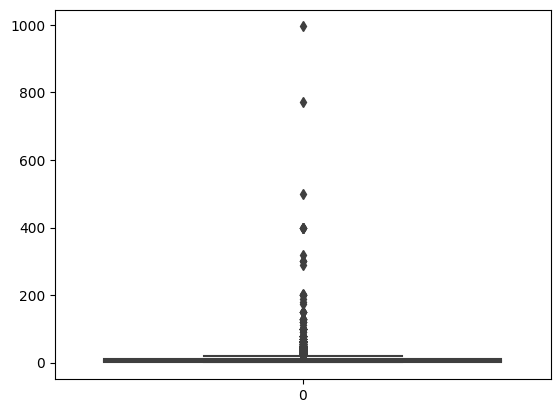

In [ ]:
sns.boxplot(data_steam.price)
plt.show()

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


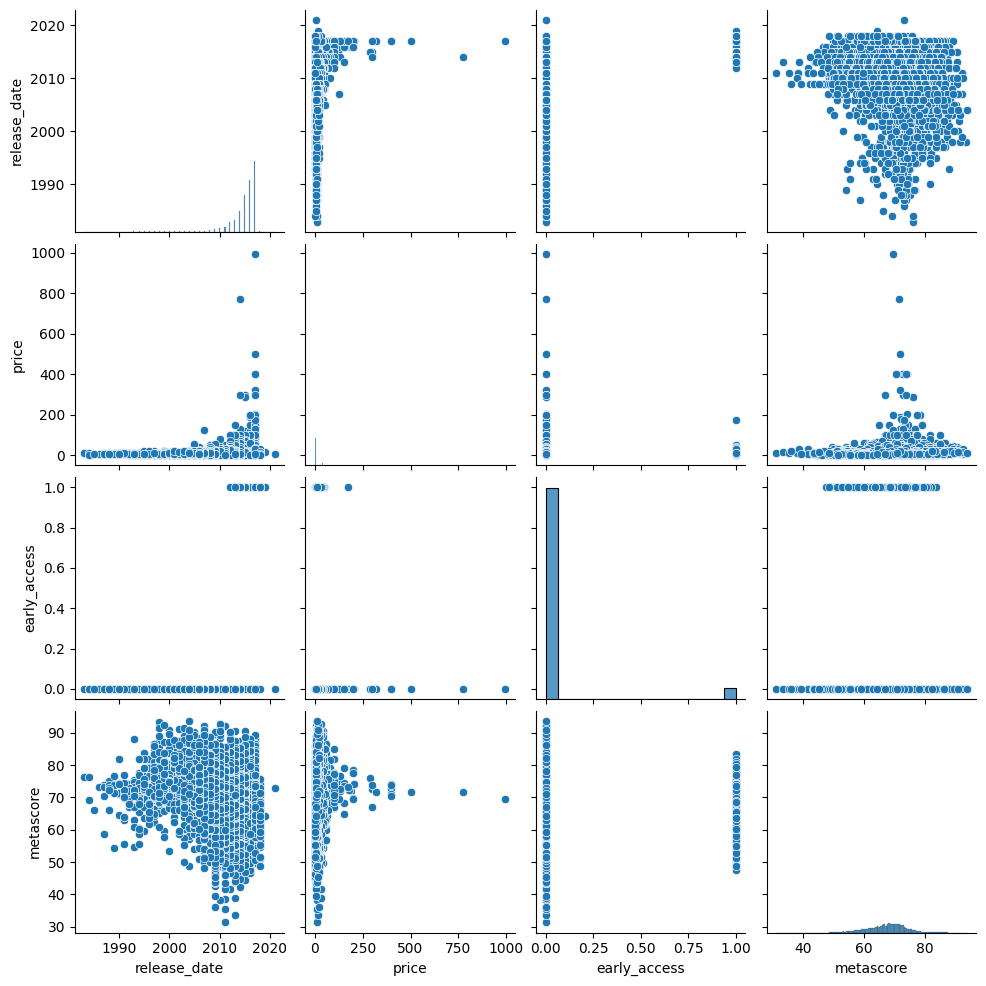

In [ ]:
sns.pairplot(data_steam)
plt.show()

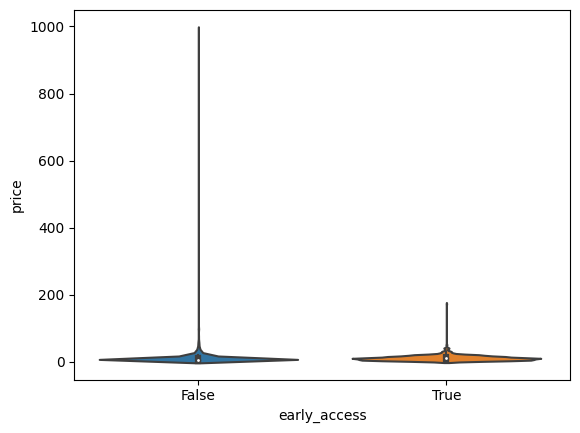

In [ ]:
sns.violinplot(x='early_access',y='price',data=data_steam,split=True)
plt.show()

In [ ]:
data_steam=data_steam.loc[data_steam.price.apply(price_game).index]

In [ ]:
Q1  = data_steam.price.quantile(0.25)
Q3  = data_steam.price.quantile(0.75)

IQR = Q3-Q1

BI_Cal = (Q1-1.5*IQR)
BS_Cal = (Q3+1.5*IQR)

print(BI_Cal, BS_Cal,data_steam.price.size)
print(data_steam.query('price>@BI_Cal and price<@BS_Cal').price.size)

-7.51 20.490000000000002 25009
23540


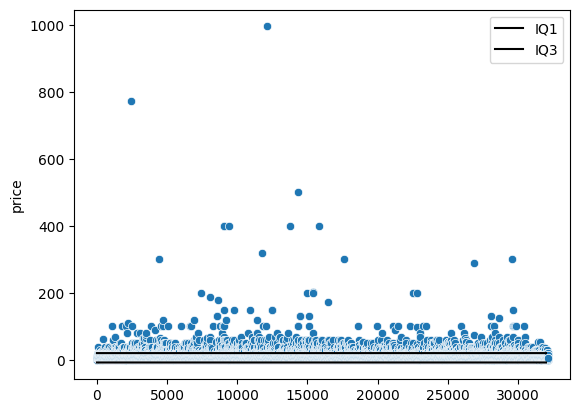

In [ ]:
sns.scatterplot(data_steam.price)
plt.plot([x for x in range(32000)],[BS_Cal for x in range(32000)], color='black', label='IQ1')
plt.plot([x for x in range(32000)],[BI_Cal for x in range(32000)], color='black',label='IQ3')
plt.legend()
plt.show()

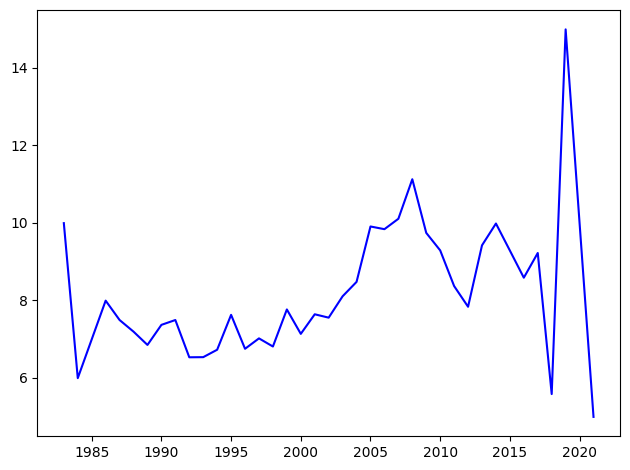

In [ ]:
data_grouped = data_steam.groupby('release_date')['price'].mean().reset_index()

plt.plot(data_grouped['release_date'], data_grouped['price'], color='blue')
plt.tight_layout()
plt.show()


In [ ]:
data_steam.price = data_steam.query('price>@BI_Cal and price<@BS_Cal').price.dropna()


0.28485379572762903


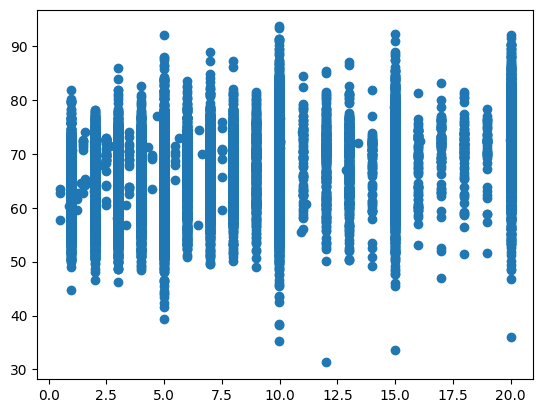

In [ ]:
print(data_steam.loc[data_steam.metascore.dropna().index]['price'].corr(data_steam.loc[data_steam.metascore.dropna().index]['metascore']))
plt.scatter(data_steam.loc[data_steam.metascore.dropna().index]['price'],data_steam.loc[data_steam.metascore.dropna().index]['metascore'])
plt.show()

In [ ]:
def unic_gen(genre):
    
    if type(genre) != float:
        return genre


In [ ]:
def unic_pr(genre):
    return len(genre)

In [ ]:
data_steam = data_steam.loc[data_steam.genres.dropna().apply(unic_gen).index]
data_steam = data_steam.loc[data_steam.specs.dropna().apply(unic_gen).index]

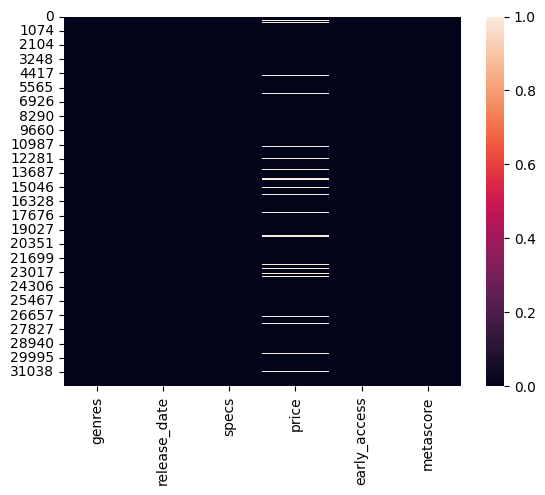

In [ ]:
sns.heatmap(data_steam.isnull())
plt.show()

In [ ]:
expanded_genres = data_steam['genres'].apply(pd.Series)
expanded_specs = data_steam['specs'].apply(pd.Series)

one_hot_genres = pd.get_dummies(expanded_genres, prefix='', prefix_sep='').groupby(level=0, axis=1).sum()
one_hot_specs = pd.get_dummies(expanded_specs, prefix='', prefix_sep='').groupby(level=0, axis=1).sum()

data_steam.drop(columns='genres', inplace=True)
data_steam.drop(columns='specs', inplace=True)

data_steam= pd.concat([data_steam,one_hot_genres],axis=1)
data_steam= pd.concat([data_steam,one_hot_specs],axis=1)

In [ ]:
data_steam.price.fillna(data_steam.price.mean(), inplace=True)

In [ ]:
data_steam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24748 entries, 0 to 32133
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   release_date                24748 non-null  int32  
 1   price                       24748 non-null  float64
 2   early_access                24748 non-null  bool   
 3   metascore                   24748 non-null  float64
 4   Action                      24748 non-null  int64  
 5   Adventure                   24748 non-null  int64  
 6   Animation &amp; Modeling    24748 non-null  int64  
 7   Audio Production            24748 non-null  int64  
 8   Casual                      24748 non-null  int64  
 9   Design &amp; Illustration   24748 non-null  int64  
 10  Early Access                24748 non-null  int64  
 11  Education                   24748 non-null  int64  
 12  Indie                       24748 non-null  int64  
 13  Massively Multiplayer       24748 no

In [ ]:
X = data_steam.drop(columns=['price'])
Y = data_steam['price']

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.25, random_state=0)

In [ ]:
multi_regress = LinearRegression()
trained_regress= multi_regress.fit(X_Train, Y_Train)

Y_Pred = trained_regress.predict(X_Test)

In [ ]:

rmse = mean_squared_error(Y_Test, Y_Pred, squared=False)
r2 = r2_score(Y_Test, Y_Pred)

print("Error Cuadrático Medio (RMSE):", rmse)

print("R2 score:", r2)

Error Cuadrático Medio (RMSE): 4.330540525078238
R2 score: 0.2832148404963516


In [ ]:
probe = X_Test.iloc[0]

In [ ]:
probe.early_access = True

C:\Users\MSI\AppData\Local\Temp\ipykernel_5656\426132857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probe.early_access = True


In [ ]:
probe.to_frame().transpose()


,release_date,early_access,metascore,Action,Adventure,Animation &amp; Modeling,Audio Production,Casual,Design &amp; Illustration,Early Access,...,Single-player,Stats,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Valve Anti-Cheat enabled
31462,2009,True,63.11,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
print(trained_regress.predict(probe.to_frame().transpose())[0])

-142949917661.1381
